# PANDA: Keras inference

Prerequisites input datasets are :
- [prostate-cancer-grade-assessment](https://www.kaggle.com/c/prostate-cancer-grade-assessment/data)
- [efficientnet](https://www.kaggle.com/huynhdoo/efficientnet)
- [pandamodels](https://www.kaggle.com/huynhdoo/pandamodels)

In [1]:
%%time
!pip install ../input/efficientnet/

Processing /kaggle/input/efficientnet
  Created wheel for efficientnet: filename=efficientnet-1.1.0-py3-none-any.whl size=18326 sha256=ed14c1d444dc769115adbfee2b58774c21afe7b90db8ce9457abb2676769e2f1
  Stored in directory: /tmp/pip-ephem-wheel-cache-a7yon4wt/wheels/67/71/1a/f0893b1c2c2e91235ac2a80e33ab5edbdfe40a58269fe1c79c
Successfully built efficientnet
CPU times: user 573 ms, sys: 137 ms, total: 710 ms
Wall time: 30.6 s


In [2]:
import warnings
warnings.filterwarnings('ignore')
import os
import cv2
import numpy as np
import pandas as pd 
import json
import skimage.io
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras import Model, Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import Sequence
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import efficientnet.tfkeras
import albumentations as albu
print('tensorflow version:', tf.__version__)
gpus = tf.config.experimental.list_physical_devices('GPU')

if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)
else:
    print('no gpus')

tensorflow version: 2.1.0
1 Physical GPUs, 1 Logical GPUs


In [3]:
# Parameters
DATA_PATH = '../input/prostate-cancer-grade-assessment'
MODELS_PATH = '.'
IMG_SIZE = 128
SEQ_LEN = 36
TARGET_SIZE = [528, 528]
BATCH_SIZE = 16
MDL_VERSION = 'v0'
SEED = 80
LEVEL = 1

## 1. Data generator
Data generator to feed neural network takes image, cut it to tiles and produces image that made of tiles:

In [4]:
# Helpers
def get_axis_max_min(array, axis=0):
    one_axis = list((array != 255).sum(axis=tuple([x for x in (0, 1, 2) if x != axis])))
    axis_min = next((i for i, x in enumerate(one_axis) if x), 0)
    axis_max = len(one_axis) - next((i for i, x in enumerate(one_axis[::-1]) if x), 0)
    return axis_min, axis_max

class DataGenPanda(Sequence):
    def __init__(self, imgs_path, df, batch_size=32, 
                 mode='fit', shuffle=False, aug=None, 
                 seq_len=SEQ_LEN, img_size=IMG_SIZE, n_classes=6):
        self.imgs_path = imgs_path
        self.df = df
        self.shuffle = shuffle
        self.mode = mode
        self.aug = aug
        self.batch_size = batch_size
        self.img_size = img_size
        self.seq_len = seq_len
        self.n_classes = n_classes
        self.side = int(seq_len ** .5)
        self.on_epoch_end()
    def __len__(self):
        return int(np.floor(len(self.df) / self.batch_size))
    def on_epoch_end(self):
        self.indexes = np.arange(len(self.df))
        if self.shuffle:
            np.random.shuffle(self.indexes)
    def __getitem__(self, index):
        X = np.zeros((self.batch_size, self.side * self.img_size, self.side * self.img_size, 3), dtype=np.float32)
        imgs_batch = self.df[index * self.batch_size : (index + 1) * self.batch_size]['image_id'].values
        for i, img_name in enumerate(imgs_batch):
            img_path = '{}/{}.tiff'.format(self.imgs_path, img_name)
            img_patches = self.get_patches(img_path)
            X[i, ] = self.glue_to_one(img_patches)
        
        # Resize image 
        X = tf.image.convert_image_dtype(X, tf.float32) # Cast and normalize the image to [0,1]    
        X = tf.image.resize(X, size = TARGET_SIZE) # standardize image size

        if self.mode == 'fit':
            y = np.zeros((self.batch_size, self.n_classes), dtype=np.float32)
            lbls_batch = self.df[index * self.batch_size : (index + 1) * self.batch_size]['isup_grade'].values
            for i in range(self.batch_size):
                y[i, lbls_batch[i]] = 1
            return X, y
        elif self.mode == 'predict':
            return X
        else:
            raise AttributeError('mode parameter error')
    def get_patches(self, img_path):
        num_patches = self.seq_len
        p_size = self.img_size
        img = skimage.io.MultiImage(img_path)[LEVEL]
        a0min, a0max = get_axis_max_min(img, axis=0)
        a1min, a1max = get_axis_max_min(img, axis=1)
        img = img[a0min:a0max, a1min:a1max, :].astype(np.float32) / 255
        if self.aug:
            img = self.aug(image=img)['image']
        pad0, pad1 = (p_size - img.shape[0] % p_size) % p_size, (p_size - img.shape[1] % p_size) % p_size
        img = np.pad(
            img,
            [
                [pad0 // 2, pad0 - pad0 // 2], 
                [pad1 // 2, pad1 - pad1 // 2], 
                [0, 0]
            ],
            constant_values=1
        )
        img = img.reshape(img.shape[0] // p_size, p_size, img.shape[1] // p_size, p_size, 3)
        img = img.transpose(0, 2, 1, 3, 4).reshape(-1, p_size, p_size, 3)
        if len(img) < num_patches:
            img = np.pad(
                img, 
                [
                    [0, num_patches - len(img)],
                    [0, 0],
                    [0, 0],
                    [0, 0]
                ],
                constant_values=1
            )
        idxs = np.argsort(img.reshape(img.shape[0], -1).sum(-1))[:num_patches]
        return np.array(img[idxs])
    
    def glue_to_one(self, imgs_seq):
        img_glue = np.zeros((self.img_size * self.side, self.img_size * self.side, 3), dtype=np.float32)
        for i, ptch in enumerate(imgs_seq):
            x = i // self.side
            y = i % self.side
            img_glue[x * self.img_size : (x + 1) * self.img_size, 
                     y * self.img_size : (y + 1) * self.img_size, :] = ptch            
        return img_glue

Load train metadata, train-test split with classes balance:

In [5]:
# Train test split
train = pd.read_csv('{}/train.csv'.format(DATA_PATH))
print('train: ', train.shape, '| unique ids:', sum(train['isup_grade'].value_counts()))
X_train, X_val = train_test_split(train, test_size=.2, stratify=train['isup_grade'], random_state=SEED)
lbl_value_counts = X_train['isup_grade'].value_counts()
class_weights = {i: max(lbl_value_counts) / v for i, v in lbl_value_counts.items()}
print('classes weigths:', class_weights)

train:  (10616, 4) | unique ids: 10616
classes weigths: {0: 1.0, 1: 1.0843881856540085, 2: 2.153631284916201, 4: 2.315315315315315, 3: 2.3269617706237424, 5: 2.362614913176711}


In [6]:
# Data generators
aug = albu.Compose(
    [
        albu.OneOf([albu.RandomBrightness(limit=.15), albu.RandomContrast(limit=.3), albu.RandomGamma()], p=.25),
        albu.HorizontalFlip(p=.25),
        albu.VerticalFlip(p=.25),
        albu.ShiftScaleRotate(shift_limit=.1, scale_limit=.1, rotate_limit=20, p=.25)
    ]
)
train_datagen = DataGenPanda(
    imgs_path='{}/train_images'.format(DATA_PATH), 
    df=X_train, 
    batch_size=BATCH_SIZE,
    mode='fit', 
    shuffle=True, 
    aug=aug, 
    seq_len=SEQ_LEN, 
    img_size=IMG_SIZE, 
    n_classes=6
)
val_datagen = DataGenPanda(
    imgs_path='{}/train_images'.format(DATA_PATH), 
    df=X_val, 
    batch_size=BATCH_SIZE,
    mode='fit', 
    shuffle=False, 
    aug=None, 
    seq_len=SEQ_LEN, 
    img_size=IMG_SIZE, 
    n_classes=6
)

test X:  (16, 528, 528, 3)
test y:  (16, 6)


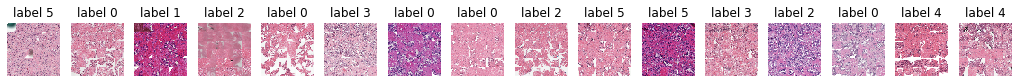

In [7]:
# Checking data generator results
Xt, yt = train_datagen.__getitem__(0)
print('test X: ', Xt.shape)
print('test y: ', yt.shape)
fig, axes = plt.subplots(figsize=(18, 6), ncols=BATCH_SIZE)
for j in range(BATCH_SIZE):
    axes[j].imshow(Xt[j])
    axes[j].axis('off')
    axes[j].set_title('label {}'.format(np.argmax(yt[j, ])))
plt.show()

## 2. Model loading

In [ ]:
# Load trained model
MODEL_DIR = '../input/pandamodels/'
models = {'B0': 'EfficientNetB0.h5', 
          'B2':'EfficientNetB2.h5', 
          'B4':'EfficientNetB4.h5', 
          'B6':'EfficientNetB6.h5', 
          'Xception':'Xception.h5'}
model = tf.keras.models.load_model(MODEL_DIR + models['B6'], compile=False)
print('Model loaded:', model)

## 3. Inference

In [ ]:
# Make prediction
test = pd.read_csv('{}/test.csv'.format(DATA_PATH))
preds = [[0] * 6] * len(test)

if os.path.exists('../input/prostate-cancer-grade-assessment/test_images'):
    print('Inference on test images...')
    subm_datagen = DataGenPanda(
        imgs_path='{}/test_images'.format(DATA_PATH), 
        df=test,
        batch_size=1,
        mode='predict', 
        shuffle=False, 
        aug=None, 
        seq_len=SEQ_LEN, 
        img_size=IMG_SIZE, 
        n_classes=6
    )
    preds = model.predict_generator(subm_datagen)
    print('Total preds test:', len(preds))
else:
    print('Inference on validation images...')
    preds = model.predict_generator(val_datagen.__getitem__(1))[:len(preds)]
    print('Total preds val:', len(preds))

In [ ]:
# Save submission file
test['isup_grade'] = np.argmax(preds, axis=1)
test.drop('data_provider', axis=1, inplace=True)
test.to_csv('submission.csv', index=False)
print('Submission saved')

In [ ]:
test.head()